## Get Data
Mengambil data dari gdelt

In [ ]:
import requests
import lxml.html as lh

gdelt_base_url = 'http://data.gdeltproject.org/events/'

# get the list of all the links on the gdelt file page
page = requests.get(gdelt_base_url+'index.html')
doc = lh.fromstring(page.content)
link_list = doc.xpath("//*/ul/li/a/@href")

# separate out those links that begin with four digits
file_list = [x for x in link_list if str.isdigit(x[0:4])]
print(file_list)

infilecounter = 0
outfilecounter = 0

import os.path
import urllib
import zipfile
import glob
import operator

local_path = 'D:/code/'

fips_country_code = 'ID'

for compressed_file in file_list[infilecounter:]:
    print(compressed_file)

    # if we dont have the compressed file stored locally, go get it. Keep trying if necessary.
    while not os.path.isfile(local_path + compressed_file):
        print('downloading, '),
        urllib.request.urlretrieve(url=gdelt_base_url + compressed_file,
                           filename=local_path + compressed_file)

    # extract the contents of the compressed file to a temporary directory
    print('extracting,'),
    try:
        z = zipfile.ZipFile(file=local_path + compressed_file, mode='r')
        z.extractall(path=local_path + 'tmp/')

        # parse each of the csv files in the working directory,
        print('parsing,'),
        for infile_name in glob.glob(local_path + 'tmp/*'):
            outfile_name = local_path + 'country/' + fips_country_code + '%04i.tsv' % outfilecounter
            # open the infile and outfile
            with open(infile_name, mode='r',encoding='utf8') as infile, open(outfile_name, mode='w',encoding='utf8') as outfile:
                for line in infile:
                    # extract lines with our interest country code
                    if fips_country_code in operator.itemgetter(51, 37, 44)(line.split('\t')):
                        outfile.write(line)
                outfilecounter += 1

            # delete the temporary file
            os.remove(infile_name)
        infilecounter += 1
        print('done')
    except:
        print("SKIP")
        infilecounter += 1
        pass

## Memindah data dari tsv ke mysql

In [ ]:
import pymysql
import pandas as pd
from sqlalchemy import create_engine

#Menyiapkan koneksi ke mysql

host = 'localhost'
port = '3306'
username = 'root'
password = ''
database = 'news'

conn = pymysql.connect(
    host=host,
    port=int(port),
    user=username,
    passwd=password,
    db=database,
    charset='utf8mb4')

#fungsi run
def run(sql):
    df = pd.read_sql_query(sql,conn)
    return df

#Create Connection to database
engine = create_engine('mysql+pymysql://'+username+':'+password+'@'+host+':'+port+'/'+database)

# #Membuat tabel gdelt_news berdasarkan header
header_file = open('header.csv','r')
data_header = header_file.read().replace('\n','')
header = data_header.split(',')

# create_table_string = "CREATE TABLE `gdelt_news` ("
# for h in header:
#     create_table_string = create_table_string+"`"+h.lower()+"` VARCHAR(255) NULL DEFAULT NULL,"
# create_table_string = create_table_string[:-1]+") COLLATE='latin1_swedish_ci' ENGINE=InnoDB;"
# engine.execute(create_table_string)

In [ ]:
#fungsi membaca file tsv dan menyimpan dalam mysql
def read_tsv(filename):
    file = open(filename, "r") 
    data = file.readlines()
    i = 0
    temp = ''
    for d in data:
        p = d.split('\t')
        insert_string = "INSERT INTO gdelt_news VALUES ("
        for index,h in enumerate(header):
            insert_string = insert_string +"'"+ p[index].replace("'","")+"',"
        insert_string = insert_string[:-1]+")"
        try:
            engine.execute(insert_string)
        except:
            print("Error:", insert_string)
        
        

In [ ]:
import os
import glob

#membaca file tsv
path = 'D:\code/gdelt_id'
extension = 'tsv'
os.chdir(path)
result = [i for i in glob.glob('*.{}'.format(extension))]
for index,r in enumerate(result):
    print("Read File",index)
    read_tsv(r)
print("Done")

## Hasil data di MySQL

In [ ]:
run("SELECT * FROM gdelt_news LIMIT 100")

## Second 

In [3]:
import pymysql
import pandas as pd
from sqlalchemy import create_engine

host = 'localhost'
port = '3306'
username = 'root'
password = ''
database = 'news'

# Create Connection to database
# engine = create_engine('mysql+pymysql://'+username+
# ':'+password+'@'+host+':'+port+'/'+database)

# Note: We use pymysql instead of sqlalchemy because sqlalchemy
# somehow don't allow the text query. Strange bug.
conn = pymysql.connect(
    host=host,
    port=int(port),
    user=username,
    passwd=password,
    db=database,
    charset='utf8mb4')
'''engine = create_engine('mysql+pymysql://root: @localhost:3306
/news')'''

def run(sql):
    df = pd.read_sql_query(sql, conn)
    return df

In [ ]:
from os import listdir
from os.path import isfile, join
folder_id = 'D:/code/gdelt_id/done/'
files = [f for f in listdir(folder_id) if isfile(join(folder_id, f))]
print(files)

In [ ]:
error = 0
for berkas in files:
    print('Read ' + berkas)
    try:
        df_satuan = pd.DataFrame()

        # Important: If your ID0000.tsv contains header, you can delete the header
        df_satuan = pd.read_csv(folder_id + berkas, sep="\t", names= header)
        df_satuan.to_sql(name = database, con = engine,if_exists = 'append', index = False)
    except:
        error = error+1
        print('Error',berkas)
print('Total error :',error)

In [ ]:
df_satuan = pd.read_csv(folder_id + "berkas", sep="\t", names= header)
df_satuan.to_sql(name = database, con = engine,if_exists = 'append', index = False)

## select by keywords

In [ ]:
data = run("""
SELECT 
    * 
FROM 
    news
WHERE
    (Year >= 2009 AND Year <= 2018) And
    (sourceurl LIKE '%criminal%' OR
    sourceurl LIKE '%crime%' OR
    
    
    sourceurl LIKE '%violence%' OR
    sourceurl LIKE '%assault%'
    
    sourceurl LIKE '%murder%' OR
    
    sourceurl LIKE '%theft%' OR
    sourceurl LIKE '%robbery%' OR
    sourceurl LIKE '%stolen%' OR
    sourceurl LIKE '%steal%' OR
    sourceurl LIKE '%burglary%' OR
    
    sourceurl LIKE '%terrorist%' OR
    
    sourceurl LIKE '%prostitute%' OR
    
    sourceurl LIKE '%corrupt%' OR
    )
    """)

In [ ]:
data.shape

In [ ]:
data_dup = data.copy()

# Remove duplicate data, keep the first occurences
data = data.drop_duplicates('SOURCEURL')
data.shape

In [ ]:
data.head()

In [ ]:
host = 'localhost'
port = '3306'
username = 'root'
password = ''
database = 'news'
database_name = 'crime_news'
engine_s = create_engine('mysql+pymysql://'+username+':'+password+'@'+host+':'
                         +port+'/'+database)
data.to_sql(database_name, engine_s)

# Save duplicated data to 'startup_indonesia_dup' table
database = 'news'
database_name_dup = 'crime_news_dup'
data_dup.to_sql(database_name_dup, engine_s)

In [128]:
data = run("""
SELECT 
     CONCAT('01/',SUBSTRING( MonthYear ,5 , 2),'/',SUBSTRING( MonthYear ,1 , 4 )) as mdate,COUNT('GLOBALEVENTID') as total
FROM 
    crime_news
WHERE Year BETWEEN 2017 AND 2018
GROUP BY MonthYear
    """)

In [ ]:
data = run("SELECT * FROM crime_news")

In [131]:
data

,mdate,total
0,01/01/2017,172
1,01/02/2017,442
2,01/03/2017,441
3,01/04/2017,203
4,01/05/2017,213
5,01/06/2017,234
6,01/07/2017,149
7,01/08/2017,146
8,01/09/2017,264
9,01/10/2017,238


In [68]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from pandas import Series

#data_selection['date'] = pd.to_datetime(data_selection['date'])
#data_selection.set_index('date', inplace = True)

#data_selection.resample('1M').plot()

data.plot()
#data_selection.plot()
plt.show()
# new_x = dates.num2date()



AttributeError: 'DataFrame' object has no attribute 'plot_date'

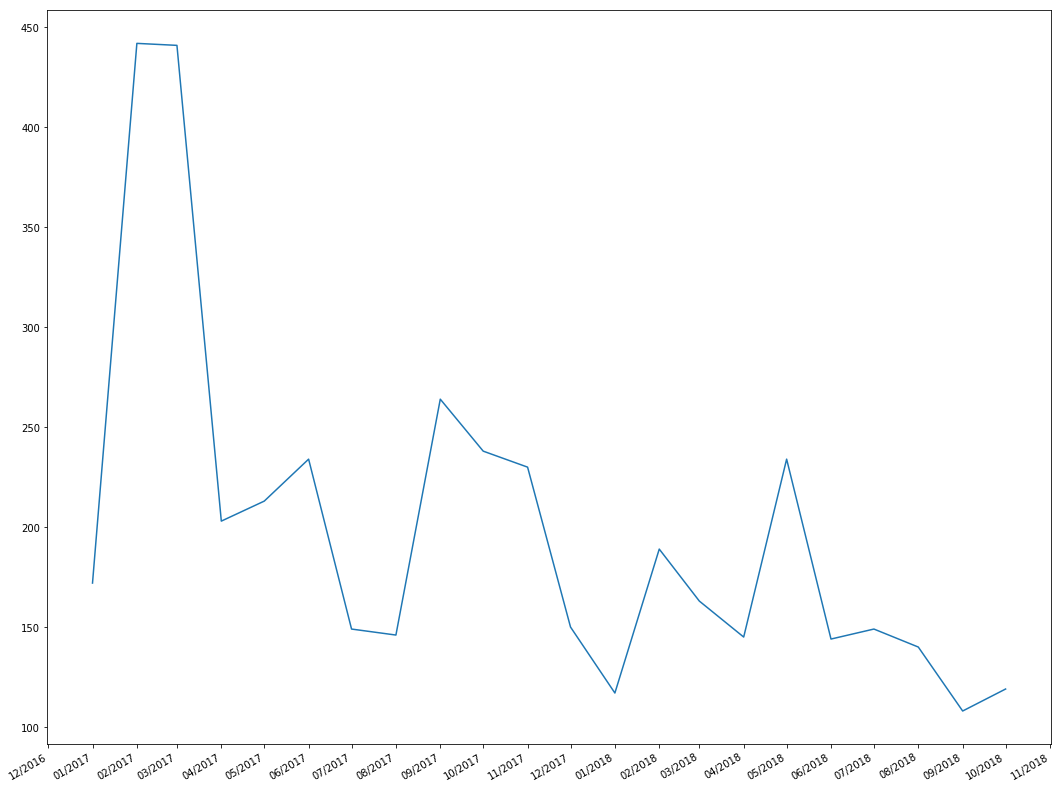

In [130]:
import datetime as dt

dates = data['mdate']
x = [dt.datetime.strptime(d,'%d/%m/%Y').date() for d in dates]
y = data['total']

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams['figure.figsize'] = [18, 15]
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.show()